In [28]:
import pickle
import numpy as np
from matplotlib import pyplot as plt

In [7]:
with open('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/ROCanalyses/LIPsampleROC', 'rb') as handle:
    lip = pickle.load(handle)

with open('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/ROCanalyses/PFCsampleROC', 'rb') as handle:
    pfc = pickle.load(handle)    

with open('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/ROCanalyses/V4sampleROC', 'rb') as handle:
    v4 = pickle.load(handle)        

['ROC value neutral',
 array([[ 0.  , -0.02, -0.02, ..., -0.06, -0.06, -0.06],
        [ 0.  ,  0.02,  0.02, ...,  0.08,  0.08,  0.06],
        [ 0.04,  0.04,  0.04, ...,  0.  ,  0.  ,  0.  ],
        ...,
        [ 0.04,  0.04,  0.06, ...,  0.2 ,  0.2 ,  0.22],
        [-0.1 , -0.1 , -0.12, ..., -0.24, -0.24, -0.24],
        [ 0.  ,  0.  ,  0.  , ..., -0.56, -0.56, -0.54]]),
 'ROC value orient',
 array([[ 0.06,  0.06,  0.06, ..., -0.06, -0.06, -0.06],
        [ 0.06,  0.06,  0.06, ...,  0.04,  0.04,  0.04],
        [-0.02, -0.02, -0.02, ..., -0.04, -0.04, -0.04],
        ...,
        [ 0.06,  0.06,  0.06, ...,  0.02,  0.02,  0.02],
        [ 0.02,  0.04,  0.04, ..., -0.1 , -0.1 , -0.12],
        [-0.02, -0.02, -0.02, ..., -0.3 , -0.3 , -0.3 ]]),
 'ROC value color',
 array([[-0.02, -0.04, -0.04, ...,  0.08,  0.08,  0.08],
        [ 0.04,  0.04,  0.02, ..., -0.12, -0.12, -0.12],
        [ 0.04,  0.04,  0.04, ..., -0.02, -0.02, -0.02],
        ...,
        [ 0.02,  0.02,  0.  , ..., -0.1

In [33]:
lip[2]

['Neutral lat',
 array([  nan,  431.,   nan,  628.,   nan,   nan, 1161.,   nan,  661.,
         832.,   nan,  703., 1275., 1220.,  450.,   nan,  459.,   nan,
          nan,  581.,   nan,   nan,   98.,   nan,   nan,   nan,  890.,
         425.,   nan,   nan,   nan,  800.,   nan, 1401.,  701.,   nan,
         468.,  599.,  712.,   nan,  632.,  813.,   nan,   nan,  837.,
          nan,   nan,  794., 1082.,  941.,   nan,   nan,  821.,   nan,
         534.,   nan,   nan,   nan,  845.,   nan,  752.,  505.,   nan,
          nan, 1365.,  813.,   nan,   nan,   nan,  356.,  415.,   nan,
        1358.,   nan,   nan,  885.,  851.,   nan,  579.,   nan,  528.,
          nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,  595.,
         510.,   nan,   nan,  502.,  517.,  721.,   nan,   nan,   nan,
         606.,  479., 1251., 1206.,   nan,   nan,   nan,   nan,   nan,
        1213.,  658.,  444.,   nan,   nan,  462.,  519., 1010., 1121.,
         464.,   nan,   nan,  732.,   nan,  737.,  459.,  506

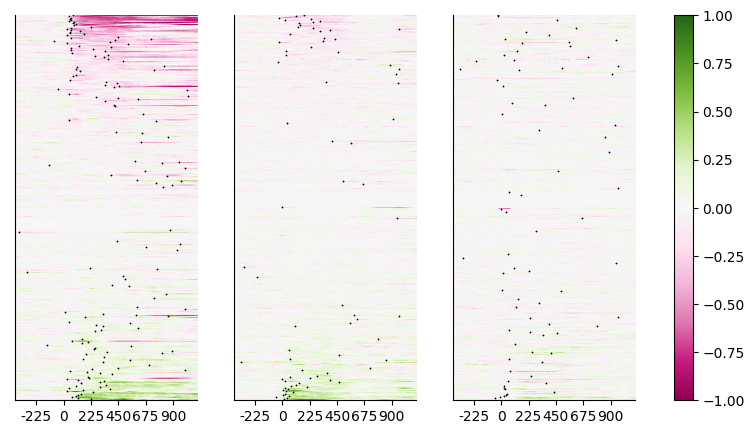

In [35]:

lip_neutral_value   =   lip[0][1]
lip_orient_value   =   lip[0][3]
lip_color_value   =   lip[0][5]

sort_neutral    =   np.argsort(np.mean(lip_neutral_value[:,450:900], axis=1))
sort_orient     =   np.argsort(np.mean(lip_orient_value[:,450:900], axis=1))
sort_color      =   np.argsort(np.mean(lip_color_value[:,450:900], axis=1))


lat_lip_neutral     =   lip[2][1]
lat_lip_orient      =   lip[2][3]
lat_lip_color       =   lip[2][5]

# fig     =   plt.figure(figsize=(10,10))
fig, ax      =   plt.subplots(1,3,figsize=(10,5))
im0       =   ax[0].imshow(lip_neutral_value[sort_neutral,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im1       =   ax[1].imshow(lip_orient_value[sort_orient,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im2       =   ax[2].imshow(lip_color_value[sort_orient,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

ax[0].scatter(lat_lip_neutral[sort_neutral], np.arange(lat_lip_neutral.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)
ax[1].scatter(lat_lip_orient[sort_orient], np.arange(lat_lip_orient.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)
ax[2].scatter(lat_lip_color[sort_color], np.arange(lat_lip_color.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)

# ax[0].x    ([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)], labels=['-225', '0', '225', '450', '675', '900'])
ax[0].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[0].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[0].set_yticks([])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[1].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[1].set_yticks([])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[2].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[2].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[2].set_yticks([])
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
fig.colorbar(im2, ax=ax)

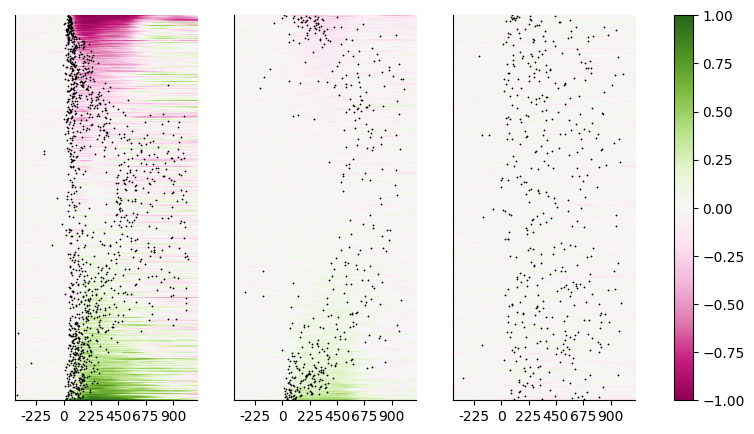

In [36]:

pfc_neutral_value   =   pfc[0][1]
pfc_orient_value   =   pfc[0][3]
pfc_color_value   =   pfc[0][5]

sort_neutral    =   np.argsort(np.mean(pfc_neutral_value[:,450:900], axis=1))
sort_orient     =   np.argsort(np.mean(pfc_orient_value[:,450:900], axis=1))
sort_color      =   np.argsort(np.mean(pfc_color_value[:,450:900], axis=1))


lat_pfc_neutral     =   pfc[2][1]
lat_pfc_orient      =   pfc[2][3]
lat_pfc_color       =   pfc[2][5]



# fig     =   plt.figure(figsize=(10,10))
fig, ax      =   plt.subplots(1,3,figsize=(10,5))
im0       =   ax[0].imshow(pfc_neutral_value[sort_neutral,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im1       =   ax[1].imshow(pfc_orient_value[sort_orient,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im2       =   ax[2].imshow(pfc_color_value[sort_orient,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

ax[0].scatter(lat_pfc_neutral[sort_neutral], np.arange(lat_pfc_neutral.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)
ax[1].scatter(lat_pfc_orient[sort_orient], np.arange(lat_pfc_orient.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)
ax[2].scatter(lat_pfc_color[sort_color], np.arange(lat_pfc_color.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)

# ax[0].x    ([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)], labels=['-225', '0', '225', '450', '675', '900'])
ax[0].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[0].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[0].set_yticks([])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[1].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[1].set_yticks([])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[2].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[2].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[2].set_yticks([])
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
fig.colorbar(im2, ax=ax)

In [38]:
v4[2]

['Neutral lat',
 array([  nan, 1320.,  719., ...,  499.,   nan,  462.]),
 'orient lat',
 array([nan, nan, nan, ..., nan, nan, nan]),
 'color lat',
 array([nan, nan, nan, ..., nan, nan, nan])]

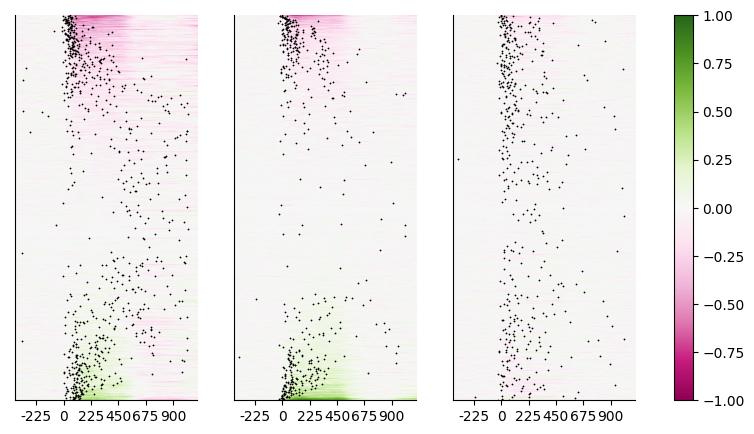

In [37]:

v4_neutral_value   =   v4[0][1]
v4_orient_value   =   v4[0][3]
v4_color_value   =   v4[0][5]

sort_neutral    =   np.argsort(np.mean(v4_neutral_value[:,450:900], axis=1))
sort_orient     =   np.argsort(np.mean(v4_orient_value[:,450:900], axis=1))
sort_color      =   np.argsort(np.mean(v4_color_value[:,450:900], axis=1))


lat_v4_neutral     =   v4[2][1]
lat_v4_orient      =   v4[2][3]
lat_v4_color       =   v4[2][5]


# fig     =   plt.figure(figsize=(10,10))
fig, ax      =   plt.subplots(1,3,figsize=(10,5))
im0       =   ax[0].imshow(v4_neutral_value[sort_neutral,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im1       =   ax[1].imshow(v4_orient_value[sort_orient,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im2       =   ax[2].imshow(v4_color_value[sort_orient,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

ax[0].scatter(lat_v4_neutral[sort_neutral], np.arange(lat_v4_neutral.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)
ax[1].scatter(lat_v4_orient[sort_orient], np.arange(lat_v4_orient.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)
ax[2].scatter(lat_v4_color[sort_color], np.arange(lat_v4_color.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)

# ax[0].x    ([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)], labels=['-225', '0', '225', '450', '675', '900'])
ax[0].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[0].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[0].set_yticks([])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[1].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[1].set_yticks([])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[2].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[2].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[2].set_yticks([])
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
fig.colorbar(im2, ax=ax)